In [1]:
# ! pip install mlxtend

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
import warnings
import spacy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from mlxtend.regressor import StackingCVRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVR
from sklearn.feature_extraction.text import CountVectorizer

from collections import Counter

import xgboost as xgb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from scipy.linalg import LinAlgWarning
warnings.simplefilter('ignore', LinAlgWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
import warnings

warnings.filterwarnings(action='ignore', category=UserWarning, message='.*X has feature names, but .* was fitted without feature names')


# Pre-processing Data

In [3]:
with open('train.pickle', 'rb') as file:
    # Load the contents of the file into a variable
    data = pickle.load(file)

In [4]:
data_v1 = [] 
for i, d in enumerate(data):
    features = d["features"]
    if bool(re.match("^desde", features[0])) == False:
        if bool(re.search("\d+ m2", features[0])) == True:
            data_v1.append(d)

In [5]:
inds = []
for i, d in enumerate(data_v1):
    features = d["features"]
    if not bool(re.match("\d hab", features[1])):
        print(i, features)
        inds.append(i)

137 ['45 m2', '1 baño', '5.689 €/m2']
186 ['113 m2', '4 baños', '2.389 €/m2']
192 ['93 m2', '1 baño', '3.215 €/m2']
503 ['54 m2', '1 baño', '6.944 €/m2']
537 ['93 m2', '1 baño', '2.151 €/m2']
574 ['102 m2', '1 baño', '3.431 €/m2']
729 ['82 m2', '22 hab.', '1 baño', '4.268 €/m2']
766 ['52 m2', '3.442 €/m2']


In [6]:
def get_new_feature(fea):
    return [fea[0], "0 hab.", fea[1], fea[-1]]

In [7]:
data_v2 = []
for i, d in enumerate(data_v1):
    features = d["features"]
    if not bool(re.match("\d hab", features[1])):
        if len(features) == 3:
            features = get_new_feature(features)
            d["features"] = features
    if len(features) == 4:
        data_v2.append(d)

In [8]:
df_train = pd.DataFrame(data_v2)
df_train

,price,title,loc_string,loc,features,type,subtype,selltype,desc
0,320.000 €,Piso Tallers. Piso con 2 habitaciones con asce...,Barcelona - Sant Antoni,None,"[85 m2, 2 hab., 1 baño, 3.647 €/m2]",FLAT,FLAT,SECOND_HAND,Piso en última planta a reformar en calle Tall...
1,335.000 €,Piso C/ de valència. Piso reformado en venta d...,Barcelona - Dreta de l´Eixample,None,"[65 m2, 2 hab., 1 baño, 5.000 €/m2]",FLAT,FLAT,SECOND_HAND,"Ubicado en la zona del Camp de l’Arpa, cerca d..."
2,330.000 €,Piso en Dreta de l´Eixample. Acogedor piso al ...,Barcelona - Dreta de l´Eixample,None,"[77 m2, 2 hab., 1 baño, 4.286 €/m2]",FLAT,FLAT,SECOND_HAND,"En pleno centro de Barcelona, justo al lado de..."
3,435.000 €,"Piso Barcelona - corts catalanes. Soleado, cén...",Barcelona - Sant Antoni,None,"[96 m2, 3 hab., 2 baños, 4.531 €/m2]",FLAT,FLAT,SECOND_HAND,"Vivienda espaciosa en Sant Antoni, cerca de Pl..."
4,410.000 €,"Piso en Carrer de sardenya 271. Alto, reformad...",Barcelona - Sagrada Família,Carrer de Sardenya 271,"[84 m2, 2 hab., 1 baño, 4.881 €/m2]",FLAT,FLAT,SECOND_HAND,"En el corazón de Barcelona, en una hermosa fin..."
...,...,...,...,...,...,...,...,...,...
857,342.000 €,Piso Meridiana,Barcelona - Navas,None,"[115 m2, 3 hab., 1 baño, 2.974 €/m2]",FLAT,FLAT,SECOND_HAND,"HANNAN-PIPER Real Estate les presenta, en excl..."
858,315.000 €,Piso en Navas. Piso con 3 habitaciones,Barcelona - Navas,None,"[82 m2, 3 hab., 1 baño, 3.841 €/m2]",FLAT,FLAT,SECOND_HAND,¡ OPORTUNIDAD !\n\nLa Casa Agency vende: Vivie...
859,360.000 €,Piso Carrer de sant antoni maria claret. Piso ...,Barcelona - Navas,None,"[79 m2, 4 hab., 2 baños, 4.557 €/m2]",FLAT,FLAT,SECOND_HAND,"Piso totalmente REFORMADO y a ESTRENAR, con MU..."
860,270.000 €,Piso Carrer del clot. Piso con calefacción y a...,Barcelona - Navas,None,"[63 m2, 1 hab., 1 baño, 4.286 €/m2]",FLAT,FLAT,SECOND_HAND,Presentamos la oportunidad de comprar un bonit...


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   price       862 non-null    object
 1   title       862 non-null    object
 2   loc_string  862 non-null    object
 3   loc         92 non-null     object
 4   features    862 non-null    object
 5   type        862 non-null    object
 6   subtype     862 non-null    object
 7   selltype    862 non-null    object
 8   desc        862 non-null    object
dtypes: object(9)
memory usage: 60.7+ KB


### Cleaning price

In [10]:
df_train['price'] = df_train['price'].str.replace('€', '', regex=False)
df_train['price'] = df_train['price'].str.replace('.', '', regex=False)
df_train['price'] = df_train['price'].astype(int)

### Cleaning features

In [11]:
size_l = list()
rooms_l = list()
bathrooms_l = list()
price_list = list()
for lis in df_train['features'].values:
    size, rooms, bathrooms, price_m2 = lis[0], lis[1], lis[2], lis[3]
    size_l.append(size)
    rooms_l.append(rooms)
    bathrooms_l.append(bathrooms)
    price_list.append(price_m2)

In [12]:
df_train['size'] = size_l
df_train['rooms'] = rooms_l
df_train['bathrooms'] = bathrooms_l
df_train['price_m2'] = price_list

In [13]:
df_train[['City', 'Neighborhood']] = (df_train['loc_string'].str.split(' - ', n=1, expand=True))

In [14]:
df_train['size'] = df_train['size'].str.split(' ', n=1, expand=True)[0]
df_train['rooms'] = df_train['rooms'].str.split(' ', n=1, expand=True)[0]
df_train['bathrooms'] = df_train['bathrooms'].str.split(' ', n=1, expand=True)[0]
df_train['price_m2'] = df_train['price_m2'].str.split(' ', n=1, expand=True)[0]

In [15]:
df_train

,price,title,loc_string,loc,features,type,subtype,selltype,desc,size,rooms,bathrooms,price_m2,City,Neighborhood
0,320000,Piso Tallers. Piso con 2 habitaciones con asce...,Barcelona - Sant Antoni,None,"[85 m2, 2 hab., 1 baño, 3.647 €/m2]",FLAT,FLAT,SECOND_HAND,Piso en última planta a reformar en calle Tall...,85,2,1,3.647,Barcelona,Sant Antoni
1,335000,Piso C/ de valència. Piso reformado en venta d...,Barcelona - Dreta de l´Eixample,None,"[65 m2, 2 hab., 1 baño, 5.000 €/m2]",FLAT,FLAT,SECOND_HAND,"Ubicado en la zona del Camp de l’Arpa, cerca d...",65,2,1,5.000,Barcelona,Dreta de l´Eixample
2,330000,Piso en Dreta de l´Eixample. Acogedor piso al ...,Barcelona - Dreta de l´Eixample,None,"[77 m2, 2 hab., 1 baño, 4.286 €/m2]",FLAT,FLAT,SECOND_HAND,"En pleno centro de Barcelona, justo al lado de...",77,2,1,4.286,Barcelona,Dreta de l´Eixample
3,435000,"Piso Barcelona - corts catalanes. Soleado, cén...",Barcelona - Sant Antoni,None,"[96 m2, 3 hab., 2 baños, 4.531 €/m2]",FLAT,FLAT,SECOND_HAND,"Vivienda espaciosa en Sant Antoni, cerca de Pl...",96,3,2,4.531,Barcelona,Sant Antoni
4,410000,"Piso en Carrer de sardenya 271. Alto, reformad...",Barcelona - Sagrada Família,Carrer de Sardenya 271,"[84 m2, 2 hab., 1 baño, 4.881 €/m2]",FLAT,FLAT,SECOND_HAND,"En el corazón de Barcelona, en una hermosa fin...",84,2,1,4.881,Barcelona,Sagrada Família
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,342000,Piso Meridiana,Barcelona - Navas,None,"[115 m2, 3 hab., 1 baño, 2.974 €/m2]",FLAT,FLAT,SECOND_HAND,"HANNAN-PIPER Real Estate les presenta, en excl...",115,3,1,2.974,Barcelona,Navas
858,315000,Piso en Navas. Piso con 3 habitaciones,Barcelona - Navas,None,"[82 m2, 3 hab., 1 baño, 3.841 €/m2]",FLAT,FLAT,SECOND_HAND,¡ OPORTUNIDAD !\n\nLa Casa Agency vende: Vivie...,82,3,1,3.841,Barcelona,Navas
859,360000,Piso Carrer de sant antoni maria claret. Piso ...,Barcelona - Navas,None,"[79 m2, 4 hab., 2 baños, 4.557 €/m2]",FLAT,FLAT,SECOND_HAND,"Piso totalmente REFORMADO y a ESTRENAR, con MU...",79,4,2,4.557,Barcelona,Navas
860,270000,Piso Carrer del clot. Piso con calefacción y a...,Barcelona - Navas,None,"[63 m2, 1 hab., 1 baño, 4.286 €/m2]",FLAT,FLAT,SECOND_HAND,Presentamos la oportunidad de comprar un bonit...,63,1,1,4.286,Barcelona,Navas


### Cleaning description

In [16]:
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    # Remove common superscripts, 'º', and 'ª'
    text = re.sub(r'[\u00B2\u00B3\u00B9\u00BA\u00AA]', '', text)  
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = text.strip()  # Remove leading and trailing spaces
    return text

In [17]:
def tokenize(text):
    winfo = list()
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    custom_dict=['baño', 'habitación', 'cocina', 'doble', 'ascensor', 'metro', 'exterior', 'salón', 'amplio',
            'finca', 'completo', 'servicio', 'comedor', 'balcón', 'dormitorio', 'inmueble', 'ciudad', 'patio', 
            'cerca', 'luminoso', 'calefacción', 'aire', 'centro', 'individual', 'verde', 'listo', 
            'reformado', 'terraza', 'acondicionado', 'transporte', 'equipado', 'independiente',
            'edificio', 'autobús', 'excelente', 'venta', 'salóncomedor', 'aluminio', 'luz', 'acceso',
            'impuesto', 'año', 'plaza', 'ducha', 'entrar', 'incluir', 'parquet', 'natural', 'honorario', 
            'reforma', 'orientación', 'armario', 'agencia', 'alto', 'hospital', 'casa', 'abierto', 'calidad', 
            'colegio', 'altura', 'ventana', 'parada', 'principal', 'gas', 'supermercado', 'madera', 'restaurante',  
            'estación', 'comercial', 'reformar', 'carpintería', 'tranquilo', 'apartamento', 'empotrado', 'lavadero', 
            'cercano', 'playa', 'bañera', 'mercado', 'hogar', 'aseo', 'orientado', 'estancia', 'vistas', 'suite', 
            'electrodoméstico', 'galería', 'mar', 'trastero', 'rodeado', 'bomba', 'departamento', 'bus', 'radiador',  
            'pequeño', 'gratuito', 'recibidor', 'comunicación', 'acabado', 'sol', 'techo', 'farmacia',
            'exclusivo', 'cristal', 'pasillo', 'sur', 'local', 'vestidor', 'corazón', 'pie', 'soleado',
            'financiación', 'único', 'sala', 'parking', 'oficina', 'moderno', 'ventanal', 'mueble', 
            'seguridad', 'agua', 'mediano', 'tranquilidad', 'plaça', 'escuela', 'conducto', 'original',
            'residencial', 'blanco', 'terrazar', 'sureste', 'office', 'cocinar', 'condición', 'céntrico', 
            'privado', 'expuesto', 'instalación', 'amueblado', 'modernista', 'integrado', 'vecino', 
            'propietario', 'despejado', 'comodidad', 'tren', 'emblemático', 'privilegiado', 'gimnasio', 
            'hipoteca', 'registro', 'alquiler', 'horno', 'noche', 'cuarto', 'estilo', 'deportivo', 'tiempo', 
            'general', 'numeroso', 'caminar', 'conservar', 'sector', 'peatonal', 'clínic', 'conexión', 
            'antiguo', 'clásico', 'frente', 'exclusiva', 'recientemente', 'frío', 'estudio', 'luminosidad', 
            'comunidad', 'oro', 'norte', 'equipamiento', 'conectado', 'eléctrico', 'llave', 'biblioteca', 
            'cuadrado', 'fachada', 'arquitectura', 'mobiliario', 'movilidad', 'rehabilitado', 'cultural', 
            'central', 'universidad', 'equipo', 'espacioso', 'familiar', 'iluminación', 'bóveda', 'urbano', 
            'variedad', 'despacho', 'nacional', 'moda', 'adicional', 'sistema', 'infantil', 'importante', 
            'persiana', 'jardín', 'proximidad', 'almacenaje', 'fríocalor', 'lavadora', 'médico', 'bar', 
            'múltiple', 'tranvía', 'universitat', 'ventilación', 'particular', 'amplitud', 'montaña', 
            'ático', 'nevera', 'cercanía', 'oeste', 'teatro', 'turístico', 'certificado', 'personal', 
            'aparcamiento', 'escalera', 'mesa', 'restauración', 'microonda', 'parques', 'balcon', 'noroeste', 
            'azotea', 'climatización', 'blindado', 'lavavajilla', 'museo', 'aeropuerto', 'piscina', 'jardines', 
            'decoración', 'transport', 'entretenimiento', 'cama', 'lavadoro', 'capital', 'vidrio', 'protección', 
            'automático', 'videoportero', 'video', 'laminado', 'lavabo', 'histórico', 'cubierto', 'caldera', 
            'marino', 'escola', 'secadoro', 'ropa', 'cubierta', 'pasear', 'negocio', 'vestíbulo', 'suroeste', 
            'lujo', 'renta', 'silencioso', 'olímpica', 'administración', 'pavimento', 'cálido', 'videovigilancia',
            'este', 'noreste', 'pileta', 'closet', 'jacuzzi', 'sauna', 'chimenea', 'alarma', 'calefactor', 'parrilla',
            'vigilancia', 'portero', 'loft', 'estudio', 'ventilador', 'playa', 'depósito', 'cuota', 'impuesto',
            'alquiler', 'claraboya', 'mármol' ]
    for token in nlp(text):
        if token.pos_ not in(['PUNCT', 'SPACE', 'IN', 'VB']) and token.lemma_ in(custom_dict) and not  token.is_stop and not url_pattern.match(token.text) and not token.like_num and len(token.text) > 2:
            winfo.append(token.lemma_)
    return winfo

In [18]:
# !python -m spacy download es_core_news_sm

In [19]:
nlp = spacy.load("es_core_news_sm")

In [20]:
df_train['desc'] = df_train['desc'].str.lower()
df_train['desc'] = df_train['desc'].apply(clean_text)
df_train['desc_tok'] = df_train['desc'].apply(tokenize)
df_train['joined_tok'] = df_train['desc_tok'].apply(lambda tokens: ' '.join(tokens))

In [21]:
# To get an idea of the words for vocabulary

# tokens = df_train['desc_tok'].values
# all_tokens = [item for sublist in tokens for item in sublist]
# tok_freq = Counter(all_tokens)
# tok_freq.most_common()
# tok_freq

In [22]:
df_train

,price,title,loc_string,loc,features,type,subtype,selltype,desc,size,rooms,bathrooms,price_m2,City,Neighborhood,desc_tok,joined_tok
0,320000,Piso Tallers. Piso con 2 habitaciones con asce...,Barcelona - Sant Antoni,None,"[85 m2, 2 hab., 1 baño, 3.647 €/m2]",FLAT,FLAT,SECOND_HAND,piso en última planta a reformar en calle tall...,85,2,1,3.647,Barcelona,Sant Antoni,"[reformar, plaza, universitat, salón, comedor,...",reformar plaza universitat salón comedor ampli...
1,335000,Piso C/ de valència. Piso reformado en venta d...,Barcelona - Dreta de l´Eixample,None,"[65 m2, 2 hab., 1 baño, 5.000 €/m2]",FLAT,FLAT,SECOND_HAND,ubicado en la zona del camp de larpa cerca de ...,65,2,1,5.000,Barcelona,Dreta de l´Eixample,"[cerca, reformado, doble, orientación, luminos...",cerca reformado doble orientación luminosidad ...
2,330000,Piso en Dreta de l´Eixample. Acogedor piso al ...,Barcelona - Dreta de l´Eixample,None,"[77 m2, 2 hab., 1 baño, 4.286 €/m2]",FLAT,FLAT,SECOND_HAND,en pleno centro de barcelona justo al lado de ...,77,2,1,4.286,Barcelona,Dreta de l´Eixample,"[centro, metro, cuadrado, finca, clásico, entr...",centro metro cuadrado finca clásico entrar rec...
3,435000,"Piso Barcelona - corts catalanes. Soleado, cén...",Barcelona - Sant Antoni,None,"[96 m2, 3 hab., 2 baños, 4.531 €/m2]",FLAT,FLAT,SECOND_HAND,vivienda espaciosa en sant antoni cerca de pl ...,96,3,2,4.531,Barcelona,Sant Antoni,"[cerca, centro, comercial, amplio, salón, come...",cerca centro comercial amplio salón comedor lu...
4,410000,"Piso en Carrer de sardenya 271. Alto, reformad...",Barcelona - Sagrada Família,Carrer de Sardenya 271,"[84 m2, 2 hab., 1 baño, 4.881 €/m2]",FLAT,FLAT,SECOND_HAND,en el corazón de barcelona en una hermosa finc...,84,2,1,4.881,Barcelona,Sagrada Família,"[corazón, finca, reformado, vistas, ascensor, ...",corazón finca reformado vistas ascensor instal...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,342000,Piso Meridiana,Barcelona - Navas,None,"[115 m2, 3 hab., 1 baño, 2.974 €/m2]",FLAT,FLAT,SECOND_HAND,hannanpiper real estate les presenta en exclus...,115,3,1,2.974,Barcelona,Navas,"[exclusiva, amplio, soleado, transporte, metro...",exclusiva amplio soleado transporte metro finc...
858,315000,Piso en Navas. Piso con 3 habitaciones,Barcelona - Navas,None,"[82 m2, 3 hab., 1 baño, 3.841 €/m2]",FLAT,FLAT,SECOND_HAND,oportunidad la casa agency vende vivienda en l...,82,3,1,3.841,Barcelona,Navas,"[casa, dormitorio, doble, mediano, individual,...",casa dormitorio doble mediano individual cocin...
859,360000,Piso Carrer de sant antoni maria claret. Piso ...,Barcelona - Navas,None,"[79 m2, 4 hab., 2 baños, 4.557 €/m2]",FLAT,FLAT,SECOND_HAND,piso totalmente reformado y a estrenar con muc...,79,4,2,4.557,Barcelona,Navas,"[reformado, luz, natural, ascensor, cocina, eq...",reformado luz natural ascensor cocina equipado...
860,270000,Piso Carrer del clot. Piso con calefacción y a...,Barcelona - Navas,None,"[63 m2, 1 hab., 1 baño, 4.286 €/m2]",FLAT,FLAT,SECOND_HAND,presentamos la oportunidad de comprar un bonit...,63,1,1,4.286,Barcelona,Navas,"[reforma, luz, despejado, frente, estación, or...",reforma luz despejado frente estación orientac...


In [23]:
X = df_train.drop(['type', 'price', 'title', 'loc_string', 'loc', 'features', 'price_m2', 'desc_tok', 'desc'], axis=1)
y = df_train['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
X_train

,subtype,selltype,size,rooms,bathrooms,City,Neighborhood,joined_tok
424,APARTMENT,SECOND_HAND,85,4,1,Barcelona,Sagrada Família,edificio apartamento dormitorio baño reformar ...
627,FLAT,SECOND_HAND,87,4,1,Barcelona,Poblenou,exterior balcón metro mar metro cerca transpor...
50,FLAT,SECOND_HAND,105,4,2,Barcelona,La Nova Esquerra de l´Eixample,amplio luminoso privilegiado peatonal inmueble...
827,FLAT,SECOND_HAND,106,4,2,Barcelona,Navas,vistas luz natural amplio exterior luz natural...
202,FLAT,SECOND_HAND,58,2,1,Barcelona,Sant Antoni,reformado acabado alto calidad centro orientac...
...,...,...,...,...,...,...,...,...
835,FLAT,SECOND_HAND,82,3,1,Barcelona,Navas,casa reformado listo entrar dormitorio doble i...
192,FLAT,SECOND_HAND,94,3,2,Barcelona,Sagrada Família,finca vistas finca corazón cercano transporte ...
629,FLAT,SECOND_HAND,63,1,1,Barcelona,El Parc i la Llacuna del Poblenou,loft venta corazón salón comedor cocinar abier...
559,FLAT,SECOND_HAND,58,1,1,Barcelona,La Nova Esquerra de l´Eixample,venta plaza venta plaza salóncomedor cocina do...


In [25]:
X_val

,subtype,selltype,size,rooms,bathrooms,City,Neighborhood,joined_tok
55,FLAT,SECOND_HAND,110,4,2,Barcelona,Fort Pienc,casa salóncomedor balcón cocina acceso habitac...
526,FLAT,SECOND_HAND,100,4,2,Barcelona,Sagrada Família,condición orientación luminoso habitación dobl...
569,GROUND_FLOOR,SECOND_HAND,110,3,2,Barcelona,El Parc i la Llacuna del Poblenou,reformar corazón terraza jardín reforma dormit...
261,FLAT,SECOND_HAND,75,4,1,Barcelona,Dreta de l´Eixample,cercano hospital colegio parada autobús habita...
31,FLAT,SECOND_HAND,90,2,1,Barcelona,L´Antiga Esquerra de l´Eixample,soleado reformar habitación galería patio refo...
...,...,...,...,...,...,...,...,...
577,FLAT,SECOND_HAND,91,4,2,Barcelona,Poblenou,venta excelente inmueble exterior orientación ...
612,FLAT,SECOND_HAND,75,2,1,Barcelona,El Parc i la Llacuna del Poblenou,venta excelente playa habitación habitación ar...
18,FLAT,SECOND_HAND,101,3,1,Barcelona,Sagrada Família,ascensor hogar propietario venta capital inmue...
278,FLAT,SECOND_HAND,69,2,1,Barcelona,Sagrada Família,cerca cercano hospital colegio parada autobús ...


In [26]:
categorical_features = ['subtype', 'selltype', 'City', 'Neighborhood']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough')

In [27]:
X_train_encoded = preprocessor.fit_transform(X_train.drop(columns=['joined_tok']))
X_val_encoded = preprocessor.transform(X_val.drop(columns=['joined_tok']))

In [28]:
feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(feature_names) + ['size', 'rooms', 'bathrooms']

In [29]:
X_train_encoded = pd.DataFrame(X_train_encoded.toarray(), columns=feature_names)
X_val_encoded = pd.DataFrame(X_val_encoded.toarray(), columns=feature_names)

In [30]:
count_v = CountVectorizer(binary=True)
X_train_desc = count_v.fit_transform(X_train['joined_tok'])
X_val_desc = count_v.transform(X_val['joined_tok'])

In [31]:
X_train_desc = pd.DataFrame(X_train_desc.toarray(), columns=count_v.get_feature_names_out())
X_val_desc = pd.DataFrame(X_val_desc.toarray(), columns=count_v.get_feature_names_out())

In [32]:
X_train = pd.concat([X_train_encoded, X_train_desc], axis=1)
X_val = pd.concat([X_val_encoded, X_val_desc], axis=1)

In [33]:
X_train

,subtype_APARTMENT,subtype_DUPLEX,subtype_FLAT,subtype_GROUND_FLOOR,subtype_LOFT,subtype_PENTHOUSE,subtype_STUDIO,selltype_SECOND_HAND,City_Barcelona,Neighborhood_Besòs - Maresme,...,vestidor,vestíbulo,video,videoportero,videovigilancia,vidrio,vigilancia,vistas,ático,único
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,1,0,1,0,0,0,0,0
685,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
686,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
687,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Random Forest Model

In [34]:
rf = RandomForestRegressor(n_estimators=100, random_state=0, criterion="absolute_error")

rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_val_pred = rf.predict(X_val)

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Training R-squared Score: {train_r2}")
print(f"Validation R-squared Score: {val_r2}")

Training R-squared Score: 0.9468422182996765
Validation R-squared Score: 0.59264141992734


In [35]:
importances = rf.feature_importances_
feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, importances))
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)


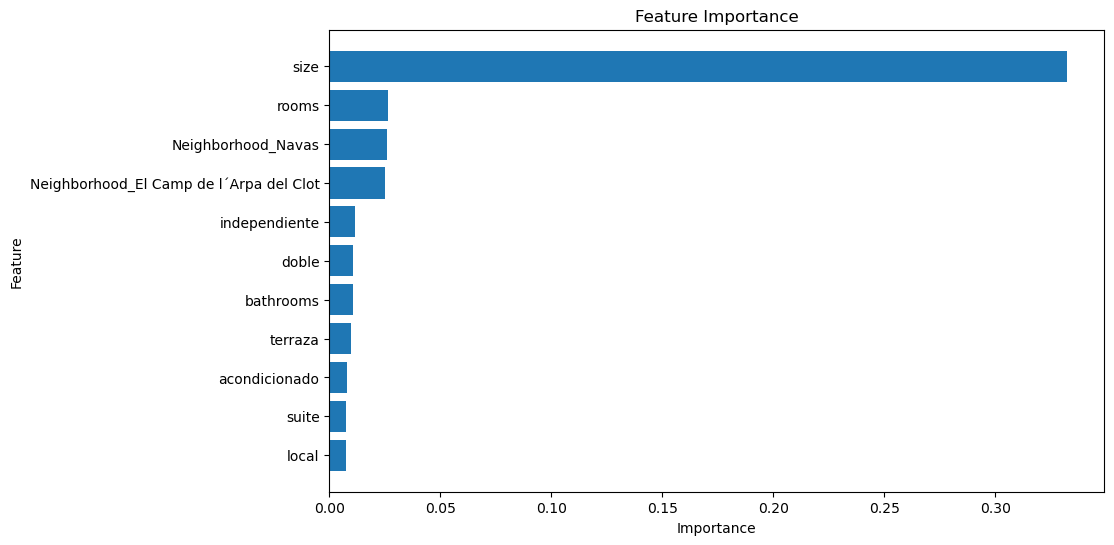

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'][0:11], feature_df['Importance'][0:11])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.title('Feature Importance')
plt.show()

# Ridge Model

In [37]:
cv = KFold(n_splits = 10, random_state = 0, shuffle = True)

In [38]:
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(with_centering=False), RidgeCV(alphas=ridge_alphas, cv=cv))
# make_pipeline first applies robustscaler to the data and then fits a ridge model with cv
# robustscaler scales so that data is more robust to outliers
ridge.fit(X_train, y_train)
ridge.score(X_val, y_val)

KeyboardInterrupt: 

In [ ]:
best_ridge_alpha = ridge.named_steps['ridgecv'].alpha_
print(f"Best alpha for Ridge: {best_ridge_alpha}")

# Lasso Model

In [ ]:
lasso_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
lasso = make_pipeline(RobustScaler(with_centering=False), LassoCV(alphas=lasso_alphas, cv=cv))
lasso.fit(X_train, y_train)
lasso.score(X_val, y_val)

In [ ]:
best_lasso_alpha = lasso.named_steps['lassocv'].alpha_
print(f"Best alpha for Lasso: {best_lasso_alpha}")

# Support Vector Regression

Fits the best line within a threshold value (epsilon) that tolerates errors on individual predictions. Objective is to find a function that has AT MOST one epsilon deviation from actual target values, and at the same time is as flat as possible. 

Parameters include kernel, which specifies which kernel type used, can be 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed', or callable. C is a regularization parameter, must be strictly positive. (and epsilon)

In [ ]:
pipeline = make_pipeline(RobustScaler(with_centering=False), SVR())

param_grid = {
    'svr__C': [100, 200, 500, 700, 900 ,1200, 1500, 2000],
    'svr__epsilon': [0.001, 0.01, 0.1, 1],
    'svr__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svr__gamma': ['scale', 'auto']  # 'gamma' is only relevant for 'rbf', 'poly', and 'sigmoid'
}

grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='r2', verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best R^2 score:", grid_search.best_score_)

In [ ]:
svr_model = SVR(kernel='linear', C=1200.0, epsilon=0.001, gamma='scale')
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_val)
r2_score(y_val, y_pred)
# Not great, but might include in blended/stacked model and see if performance increases

# XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.2, 0.4, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=10, scoring='r2', verbose=1, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
print("Best parameters:", grid_search.best_params_)

best_xgb_model = grid_search.best_estimator_

predictions = best_xgb_model.predict(X_val)

print('R^2 score:', r2_score(y_val, predictions))

# catboost

In [ ]:
from catboost import CatBoostRegressor

catboost = CatBoostRegressor(random_state=0, verbose=0)  # `verbose=0` to silence training output

catboost.fit(X_train, y_train)

y_train_pred_catboost = catboost.predict(X_train)
y_val_pred_catboost = catboost.predict(X_val)

train_r2_catboost = r2_score(y_train, y_train_pred_catboost)
val_r2_catboost = r2_score(y_val, y_val_pred_catboost)

print(f"CatBoost R-squared Score on Training Set: {train_r2_catboost}")
print(f"CatBoost R-squared Score on Validation Set: {val_r2_catboost}")


"Category Boosting" is particularly good at handling categorical features directly. It is a gradient boosting framework, built by starting off with a simple model (decision tree) and iteratively adds new models that corrects the errors made by the previous models. 

Uses "ordered boosting" to solve the overfitting issue in many gradient boosting methods. Instead of using the entire dataset to calculate the gradient, catboost just uses a randomly ordered subset of the data for each iteration. Uses L2 regularization. 

# Stacked Model

In stacking ensemble models, the meta-regressor is a second-level model that learns how to best combine the predictions from the first level models (regressors) to make a final prediction. 

The first-level models are just individual models trained on the training data. The first-level models make predictions on a validation set or through cross-validation on the training set. These predictions, known as meta-features, serve as the input features for the meta-regressor.

The meta-regressor is trained on these features, essentially trying to learn from the mistakes of the first level models and improve the final prediction. 

Use different models for the regressors as each model might be capturing an aspect of the data the other models are not. 

In [ ]:
stack = StackingCVRegressor(regressors=(lasso, ridge, rf, best_xgb_model, catboost, svr_model),
                            meta_regressor=catboost,
                            use_features_in_secondary=True)

In [ ]:
stack.fit(X_train, y_train)

predictions = stack.predict(X_val)

r2 = r2_score(y_val, predictions)

print(f'R^2 Score: {r2}')
# slightly random everytime due to using rf as the meta_regressor

# Blend Models

We blend the models in order to make the final predictions more robust to overfitting. 

In [ ]:
def blended_predictions(X):
    return ((0.05 * ridge.predict(X))+
            (0.05 * lasso.predict(X)) +
            (0.03 * svr_model.predict(X)) +
            (0.35 * rf.predict(X)) +
            (0.12 * catboost.predict(X)) +
            (0.4 * stack.predict(X)) # optional depending on performace of blend
            )

In [ ]:
blended_train_score = r2_score(y_train, blended_predictions(X_train))
print('R-2 Score on train data:', blended_train_score)

In [ ]:
blended_val_score = r2_score(y_val, blended_predictions(X_val))
print('R-2 Score on val data:', blended_val_score)
# R-2 Score on val data: 0.6824937211257893 with 0.4 rf 0.5 stack
# stack model had ~0.69 val r-2, but blending improves generalization (usually)

# Predictions for Test Data Using Blended Model

In [ ]:
with open('test_kaggle.pickle', 'rb') as file_test:
    # Load the contents of the file into a variable
    test_data = pickle.load(file_test)

In [ ]:
data_v1_test = [] 
for i, d in enumerate(test_data):
    features = d["features"]
    if bool(re.match("^desde", features[0])) == False:
        if bool(re.search("\d+ m2", features[0])) == True:
            data_v1_test.append(d)

In [ ]:
data_v2_test = []
for i, d in enumerate(data_v1_test):
    features = d["features"]
    if not bool(re.match("\d hab", features[1])):
        if len(features) == 3:
            features = get_new_feature(features)
            d["features"] = features
    if len(features) == 4:
        data_v2_test.append(d)

In [ ]:
for i, d in enumerate(data_v2_test):
    features = d["features"]
    if not bool(re.match("\d baño", features[2])):
        print(i, features)

In [ ]:
df_test = pd.DataFrame(data_v1_test)

In [ ]:
size_list = list()
rooms_list = list()
bathrooms_list = list()

for lis in df_test['features'].values:
    size, rooms, bathrooms = lis[0], lis[1], lis[2]
    size_list.append(size)
    rooms_list.append(rooms)
    bathrooms_list.append(bathrooms)

In [ ]:
df_test['size'] = size_list
df_test['rooms'] = rooms_list
df_test['bathrooms'] = bathrooms_list
df_test[['City', 'Neighborhood']] = (df_test['loc_string'].str.split(' - ', n=1, expand=True))

In [ ]:
df_test['size'] = df_test['size'].str.split(' ', n=1, expand=True)[0]
df_test['rooms'] = df_test['rooms'].str.split(' ', n=1, expand=True)[0]
df_test['bathrooms'] = df_test['bathrooms'].str.split(' ', n=1, expand=True)[0]

In [ ]:
df_test['desc'] = df_test['desc'].str.lower()
df_test['desc'] = df_test['desc'].apply(clean_text)
df_test['desc_tok'] = df_test['desc'].apply(tokenize)
df_test['joined_tok'] = df_test['desc_tok'].apply(lambda tokens: ' '.join(tokens))

In [ ]:
X_test = df_test.drop(['title', 'loc_string', 'loc', 'features', 'desc_tok', 'desc'], axis=1)

In [ ]:
X_test_encoded = preprocessor.transform(X_test.drop(columns=['joined_tok']))

In [ ]:
feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(feature_names) + ['size', 'rooms', 'bathrooms']

In [ ]:
X_test_encoded = pd.DataFrame(X_test_encoded.toarray(), columns=feature_names)

In [ ]:
X_test_desc = count_v.transform(X_test['joined_tok'])
X_test_desc = pd.DataFrame(X_test_desc.toarray(), columns=count_v.get_feature_names_out())

In [ ]:
X_test_final = pd.concat([X_test_encoded, X_test_desc], axis=1)

In [ ]:
pred_blended = blended_predictions(X_test_final)

In [ ]:
ids = list(range(len(pred_blended)))

In [ ]:
submission_df = pd.DataFrame({
    'id': ids,
    'price': pred_blended
})

In [ ]:
submission_df

In [ ]:
submission_df.to_csv('solutions.csv', index=False)

# pytorch

In [ ]:
train_features = torch.tensor(X_train.values, dtype=torch.float32)
train_targets = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
val_features = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

In [ ]:
train_dataset = TensorDataset(train_features, train_targets)
val_dataset = TensorDataset(val_features, val_targets)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class DeeperRegressionNet(nn.Module):
    def __init__(self, num_features):
        super(DeeperRegressionNet, self).__init__()
        self.layer1 = nn.Linear(num_features, 256)  # First hidden layer
        self.layer2 = nn.Linear(256, 128)  # Second hidden layer
        self.layer3 = nn.Linear(128, 64)  # Third hidden layer
        self.layer4 = nn.Linear(64, 32)  # Fourth hidden layer
        self.output_layer = nn.Linear(32, 1)  # Output layer for regression
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = self.output_layer(x)
        return x


model = DeeperRegressionNet(X_train.shape[1])

# Why does 4 layers with those dimensions seem to be the best with current features?

is it because our data is not that complex? or because our dataset is small? both?

ReLu activation function,basically sets all negatives in input to 0 and keeps positives unchanged. Each time you feed input into the relu, essentially adding non-linearity to help capture more complex patterns in the data. However, for our relatively small dataset with only 7 features (before encoding), nerual nets might not be the best method. 

However, could include in the stack/blended model to improve generality as it could capture some aspect of the data the other models do not. 

In [ ]:
# Define the optimizer with L2 regularization (weight_decay)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Adjust weight_decay for L2 regularization strength

# Define the loss function
criterion = nn.MSELoss()

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    for batch_features, batch_targets in train_loader:
        optimizer.zero_grad()  # Clear gradients
        outputs = model(batch_features)  # Forward pass
        loss = criterion(outputs, batch_targets)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

    # Optional: Evaluate on validation set every epoch
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for val_features, val_targets in val_loader:
            val_outputs = model(val_features)
            val_loss += criterion(val_outputs, val_targets).item()
        val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss}')


In [ ]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for val_features, val_targets in val_loader:
        val_outputs = model(val_features)
        predictions.extend(val_outputs.view(-1).tolist())
        actuals.extend(val_targets.view(-1).tolist())

print('R^2 score:', r2_score(actuals, predictions))

In [ ]:
predictions